In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
from IPython.display import clear_output
%matplotlib inline

from utils import *

# Create the dataset
Modified from \
https://github.com/ironfrown/qtsa_workshop/blob/main/utils.py

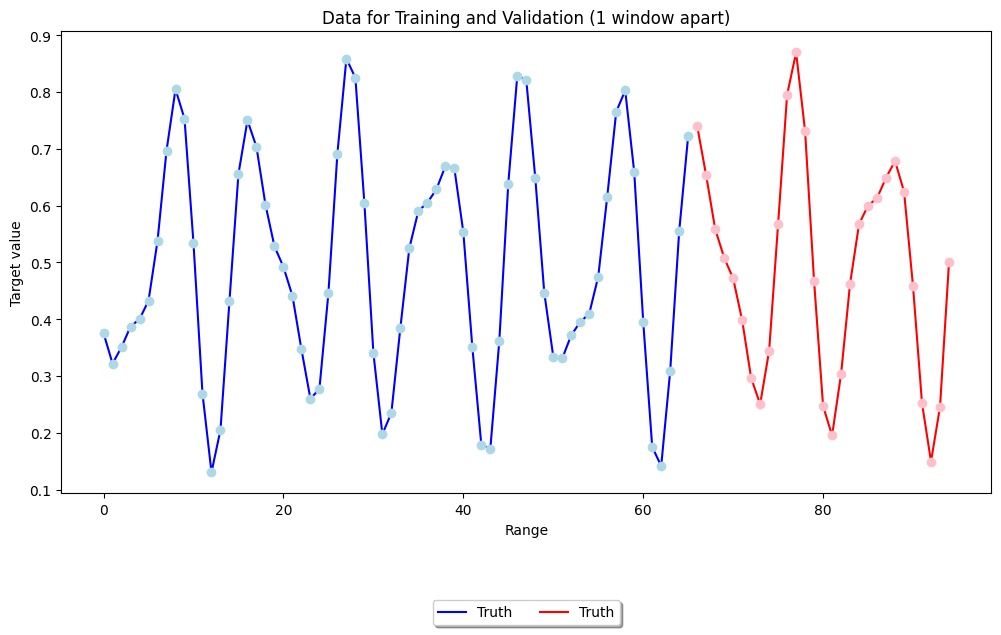

In [3]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples = 50
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 5
wind_step = 1
horizon = 1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
y_all = f.fun(X_all)

# Prepare X and y for training
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = Xy_wind_split(y_all, wind_size, wind_step, horizon, train_pc)

# Plot prepared data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='blue', label='Truth')
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], color='red', label='Truth')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

In [4]:
from pprint import pprint

### Show a sample of data
print('\nOriginal training examples (20 y values, X is ignored):')
pprint(y_all[0:20])
print('\nTS X train examples (5 records):')
pprint(X_train_ts[0:5,:])
print('\nTS y train examples (5 records):')
pprint(y_train_ts[0:5,:])
print('\nTS X, y train shape:', X_train_ts.shape, y_train_ts.shape)
print('TS X, y valid shape:', X_valid_ts.shape, y_valid_ts.shape, '\n')


Original training examples (20 y values, X is ignored):
array([0.5       , 0.75444266, 0.85072478, 0.74813221, 0.54229474,
       0.37529953, 0.32180385, 0.35086342, 0.3869433 , 0.40005637,
       0.43250985, 0.53759593, 0.69649509, 0.80470206, 0.75302619,
       0.5335143 , 0.26909808, 0.13031512, 0.2050119 , 0.43217518])

TS X train examples (5 records):
array([[0.5       , 0.75444266, 0.85072478, 0.74813221, 0.54229474],
       [0.75444266, 0.85072478, 0.74813221, 0.54229474, 0.37529953],
       [0.85072478, 0.74813221, 0.54229474, 0.37529953, 0.32180385],
       [0.74813221, 0.54229474, 0.37529953, 0.32180385, 0.35086342],
       [0.54229474, 0.37529953, 0.32180385, 0.35086342, 0.3869433 ]])

TS y train examples (5 records):
array([[0.37529953],
       [0.32180385],
       [0.35086342],
       [0.3869433 ],
       [0.40005637]])

TS X, y train shape: (66, 5) (66, 1)
TS X, y valid shape: (29, 5) (29, 1) 



In [4]:
from __future__ import annotations

from typing import List, Sequence, Tuple, Union
import numpy as np

ArrayLike1D = Union[np.ndarray, Sequence[float]]

def trend_analyser(segment: np.ndarray, delta: float = 0.0) -> int:
    start = float(segment[0])
    end = float(segment[-1])
    diff = end - start
    if diff > delta:
        return 1
    elif diff < -delta:
        return -1
    else:
        return 0

def paa_segments(y: ArrayLike1D, w: int) -> np.ndarray:
    """
    Split y into w equal-length contiguous segments (requires n % w == 0).

    Returns
    -------
    np.ndarray
        shape (w, n//w)
    """
    y = np.asarray(y, dtype=float).reshape(-1)
    n = len(y)
    if w <= 0:
        raise ValueError("w must be a positive integer.")
    if n % w != 0:
        raise ValueError(f"n={n} not divisible by w={w}. Choose w that divides n.")
    return y.reshape(w, n // w)

def paa_trend_pairs(y: ArrayLike1D, w: int, delta: float = 0.0) -> List[Tuple[float, int]]:
    """
    Compute (PAA mean, trend) per segment.

    Output format:
        [(paa_val, trend), (paa_val, trend), ...]

    where:
        paa_val = mean of the segment
        trend   = +1 if end-start >  delta
                  -1 if end-start < -delta
                   0 otherwise
    """
    segs = paa_segments(y, w=w)
    out: List[Tuple[float, int]] = []
    for seg in segs:
        paa_val = float(np.mean(seg))
        trend = trend_analyser(seg, delta=delta)
        out.append((paa_val, trend))
    return out


In [5]:
# Example: with your two_sins_series
x, y = two_sins_series(n_points=70, x_start=1.0, x_end=10.0)
pairs = paa_trend_pairs(y, w=10, delta=0.02)
pairs[:5], len(pairs)


([(0.5973215357301458, 1),
  (0.4137083590781094, 1),
  (0.44711349425162583, -1),
  (0.5901423025102227, -1),
  (0.5012298830601686, 1)],
 10)

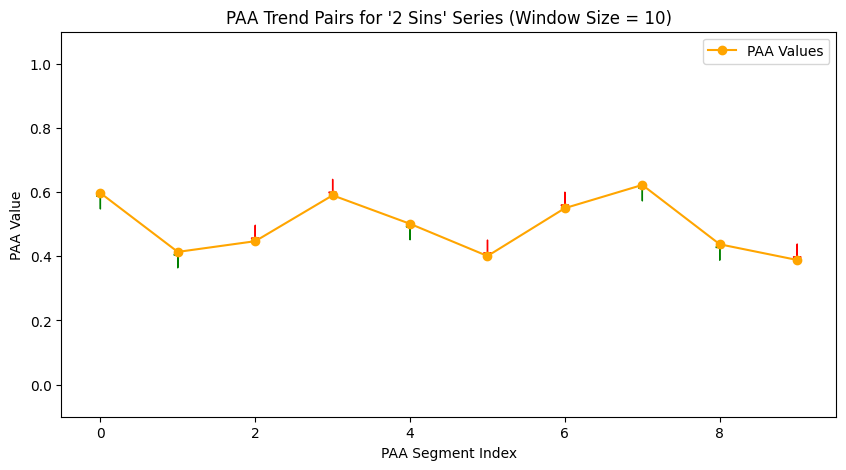

In [6]:

# Visualize the PAA trend pairs
paa_vals, trends = zip(*pairs)
indices = range(len(paa_vals))
plt.figure(figsize=(10, 5))
plt.plot(indices, paa_vals, marker="o", color="orange", label="PAA Values")
for i, trend in zip(indices, trends):
    if trend == 1:
        plt.arrow(i, paa_vals[i] - 0.05, 0, 0.04, head_width=0.1, head_length=0.02, fc='green', ec='green')
    elif trend == -1:
        plt.arrow(i, paa_vals[i] + 0.05, 0, -0.04, head_width=0.1, head_length=0.02, fc='red', ec='red')
plt.title("PAA Trend Pairs for '2 Sins' Series (Window Size = 10)")
plt.xlabel("PAA Segment Index")
plt.ylabel("PAA Value")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

In [7]:
from __future__ import annotations

from typing import Optional, Sequence, Union
import numpy as np
import matplotlib.pyplot as plt

ArrayLike1D = Union[np.ndarray, Sequence[float]]

def plot_paa_trend(
    y: ArrayLike1D,
    w: int,
    delta: float = 0.0,
    x: Optional[ArrayLike1D] = None,
    title: Optional[str] = None,
    marker_size: int = 3,
    show_chords: bool = True,
    show_delta_bands: bool = True,
) -> None:
    y = np.asarray(y, dtype=float).reshape(-1)
    n = len(y)

    if x is None:
        x = np.arange(n, dtype=float)
    else:
        x = np.asarray(x, dtype=float).reshape(-1)
        if len(x) != n:
            raise ValueError(f"x and y must have the same length (got {len(x)} vs {n}).")

    if w <= 0:
        raise ValueError("w must be a positive integer.")
    if n % w != 0:
        raise ValueError(f"n={n} not divisible by w={w}. Choose w that divides n.")

    seg_len = n // w
    segs = paa_segments(y, w=w)
    trends = np.array([trend_analyser(seg, delta=delta) for seg in segs], dtype=int)
    paa_vals = np.array([float(np.mean(seg)) for seg in segs], dtype=float)

    print("Segment trends:", trends.tolist())
    print("Counts:", {k: int((trends == k).sum()) for k in (-1, 0, 1)})
    print("PAA+trend pairs:", list(zip(paa_vals.tolist(), trends.tolist())))

    plt.figure()
    plt.plot(x, y, marker="o", markersize=marker_size)

    for i in range(w):
        start_idx = i * seg_len
        end_idx = (i + 1) * seg_len - 1

        plt.axvline(x[start_idx], linestyle=":", linewidth=1)

        mid_x = (x[start_idx] + x[end_idx]) / 2.0
        top = float(np.max(y[start_idx:end_idx + 1]))
        plt.text(mid_x, top + 0.03, f"{trends[i]}", ha="center", va="bottom")

        if show_chords:
            plt.plot([x[start_idx], x[end_idx]],
                     [y[start_idx], y[end_idx]],
                     linestyle="--", linewidth=1)

        if show_delta_bands and delta > 0:
            plt.hlines([y[start_idx] + delta, y[start_idx] - delta],
                       xmin=x[start_idx], xmax=x[end_idx],
                       linestyles=":", linewidth=1)

    plt.axvline(x[-1], linestyle=":", linewidth=1)
    plt.title(title if title is not None else f"PAA segments (w={w}) with trend labels (delta={delta})")
    plt.xlabel("x" if x is not None else "index")
    plt.ylabel("value")
    plt.tight_layout()
    plt.show()


Segment trends: [1, 1, -1, -1, 1, -1, -1, 1, 1, -1]
Counts: {-1: 5, 0: 0, 1: 5}
PAA+trend pairs: [(0.5973215357301458, 1), (0.4137083590781094, 1), (0.44711349425162583, -1), (0.5901423025102227, -1), (0.5012298830601686, 1), (0.40089838690728874, -1), (0.5501604534198752, -1), (0.6224032940918385, 1), (0.4374186614656393, 1), (0.38855575230660716, -1)]


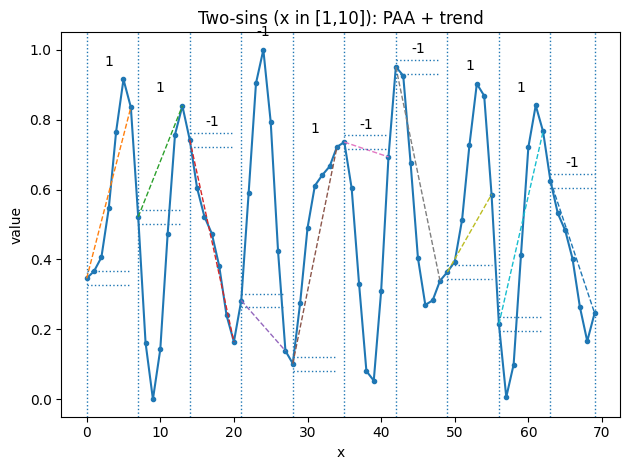

In [8]:
x, y = two_sins_series(n_points=70, x_start=1.0, x_end=10.0)
plot_paa_trend(y, w=10, delta=0.02, title="Two-sins (x in [1,10]): PAA + trend")


In [1]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 42

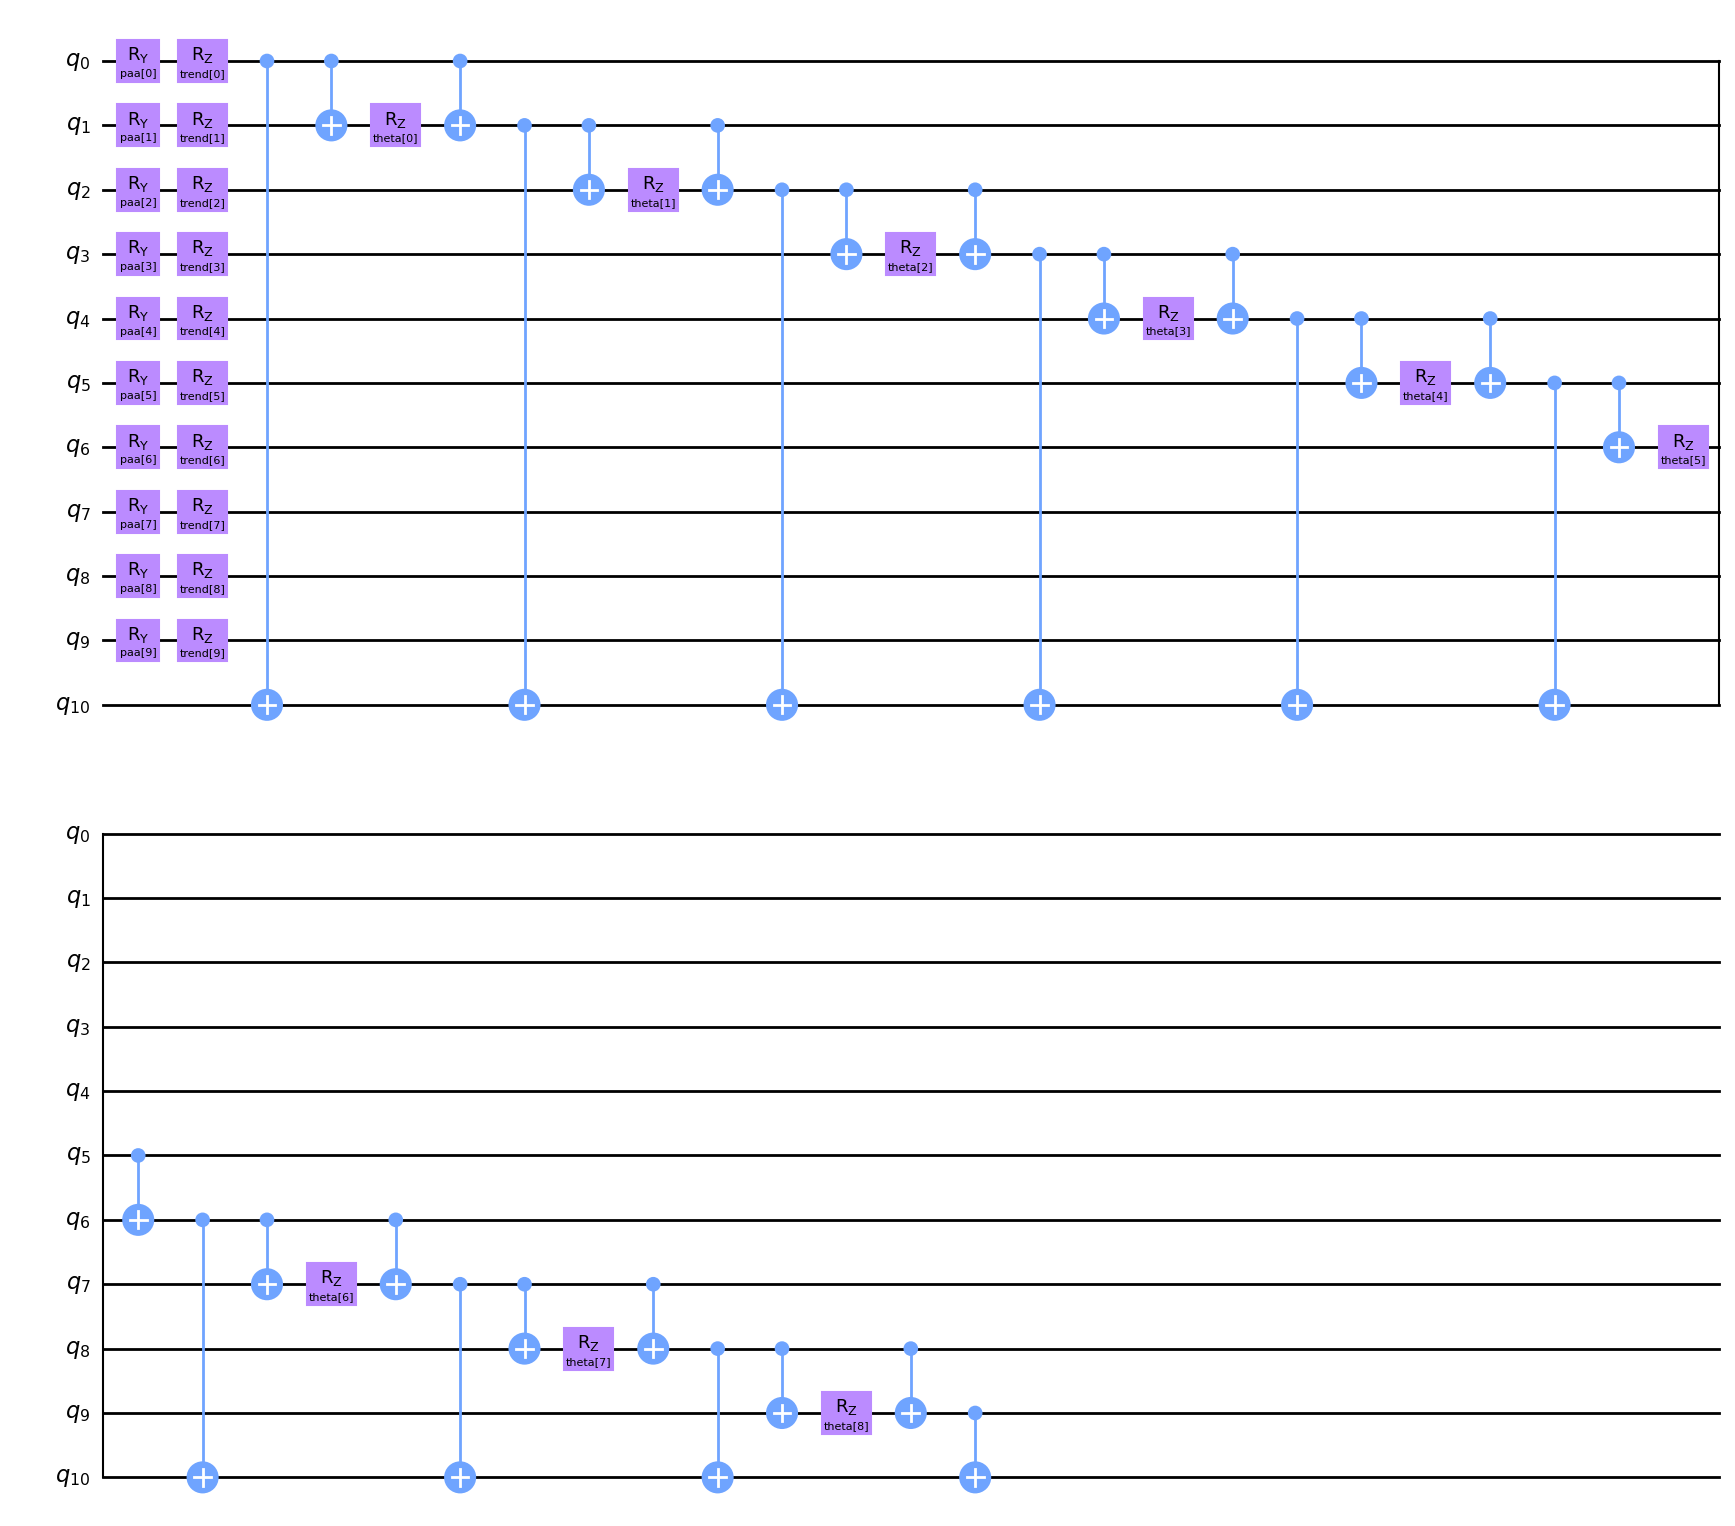

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

n_data = 10
n_qubits = n_data + 1
head = n_qubits - 1

paa = ParameterVector("paa", n_data)
trend = ParameterVector("trend", n_data)
theta = ParameterVector("theta", n_data - 1)

qc = QuantumCircuit(n_qubits)

for i in range(n_data):
    qc.ry(paa[i], i)
    qc.rz(trend[i], i)

for i in range(n_data - 1):
    qc.cx(i, head)
    qc.cx(i, i + 1)
    qc.rz(theta[i], i + 1)
    qc.cx(i, i + 1)

qc.cx(n_data - 1, head)

qc.draw("mpl", style="clifford")

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()
estimator_qnn = EstimatorQNN(
    circuit=qc1,
    observables=observable1,
    input_params=[params1[0]],
    weight_params=[params1[1]],
    estimator=estimator,
)
estimator_qnn

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


# Blocks: Serial entangler (CNOT–RZ–CNOT) + angle encoding

# Ansatz: TwoLocal block

In [11]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import TwoLocal

def twolocal_ansatz(num_qubits: int, label: str = "W") -> tuple[QuantumCircuit, list]:
    qr = QuantumRegister(num_qubits, "data")
    qc = QuantumCircuit(qr, name="ANSATZ")

    w_block = TwoLocal(
        num_qubits,
        rotation_blocks=["rx", "ry", "rz"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
        parameter_prefix=label,
        insert_barriers=True,
        skip_final_rotation_layer=False,
    )

    qc.append(w_block, qr)
    return qc, list(w_block.parameters)


In [6]:
from qiskit.circuit import ParameterVector

# Binding PAA vector into the input parameters

In [12]:
from qiskit import QuantumCircuit, QuantumRegister

def build_model(num_data_qubits: int, add_meas: bool = False):
    """
    Full model = PAA+trend feature map (A) + ansatz.
    """
    num_qubits = num_data_qubits + 1  # include head
    qr = QuantumRegister(num_qubits, "data")
    model = QuantumCircuit(qr, name="PAA_TREND_VQC")

    # Feature map
    enc, paa, trend = encode_paa_trend_block(num_data_qubits)
    zz, theta = zz_chain_with_head_funnel(num_data_qubits)

    model.append(enc.to_instruction(), qr[:num_data_qubits])
    model.barrier()
    model.append(zz.to_instruction(), qr)

    # Ansatz
    ans, weights = twolocal_ansatz(num_qubits)
    model.barrier()
    model.append(ans.to_instruction(), qr)

    if add_meas:
        model.measure_all()

    input_params = list(paa) + list(trend)
    weight_params = list(theta) + list(weights)

    return model, input_params, weight_params


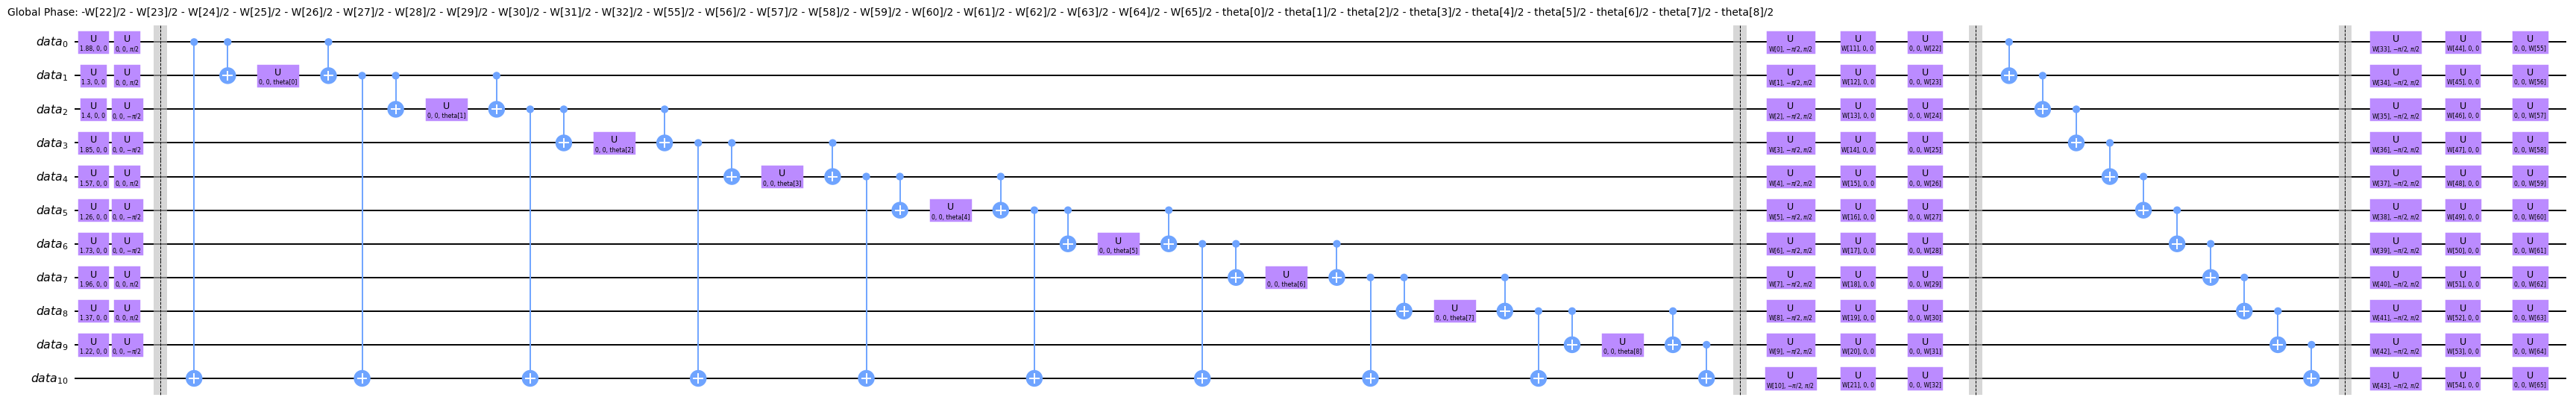

In [13]:
import numpy as np

# --- data -> angles ---
def pairs_to_angles(
    pairs,
    paa_scale=np.pi,
    trend_scale=np.pi / 2,
):
    """
    (paa_i, trend_i) -> (alpha_i, beta_i)
    alpha_i = pi * paa_i
    beta_i  = (pi/2) * trend_i
    """
    paa = np.array([p for p, _ in pairs], dtype=float)
    trend = np.array([s for _, s in pairs], dtype=float)

    return paa_scale * paa, trend_scale * trend


num_data_qubits = 10

# build unbound model
qc, input_params, weight_params = build_model(num_data_qubits)

# convert sample to angles
paa_angles, trend_angles = pairs_to_angles(pairs)

# bind ONLY data parameters
data_bind = {}

for p, val in zip(input_params[:num_data_qubits], paa_angles):
    data_bind[p] = float(val)

for p, val in zip(input_params[num_data_qubits:], trend_angles):
    data_bind[p] = float(val)

# circuit with data frozen, weights still symbolic
qc_data_bound = qc.assign_parameters(data_bind, inplace=False)


# visualize
qc_full = qc_data_bound.decompose(reps=10)
qc_full.draw(output="mpl", style="clifford", fold=120, scale=0.7)


In [14]:
from qiskit.utils import QuantumInstance
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100, seed_simulator=2022, seed_transpiler=2022)

ImportError: cannot import name 'QuantumInstance' from 'qiskit.utils' (/home/benja/SIT746---Research-Project/sit746env/lib/python3.12/site-packages/qiskit/utils/__init__.py)

In [16]:
# Old way (will raise the ImportError)
# from qiskit.utils import QuantumInstance
# vqe = VQE(ansatz, optimizer, quantum_instance=quantum_instance)

# New way using primitives
from qiskit_algorithms import VQE
from qiskit_ibm_runtime import Sampler # or Estimator, depending on the need
from qiskit_aer import AerSimulator # Use Aer for local simulation

# 1. Define your ansatz and optimizer as before
# ansatz = ...
# optimizer = ...

# 2. Instantiate a backend or simulator
simulator = AerSimulator()

# 3. Create a Sampler or Estimator instance (e.g., for VQE, you often use an Estimator)
# Note: Sampler/Estimator handle the execution details that QuantumInstance used to
# For local simulation, you instantiate the primitive with the backend
sampler = Sampler(backend=simulator) 

# 4. Pass the primitive instance to the algorithm
# vqe = VQE(ansatz=ansatz, optimizer=optimizer, sampler=sampler)

TypeError: SamplerV2.__init__() got an unexpected keyword argument 'backend'

In [74]:
from qiskit.quantum_info import SparsePauliOp

num_qubits = qc.num_qubits
trend_obs = SparsePauliOp.from_list(
    [("I" * (num_qubits - 1) + "Z", 1.0)]
)


In [83]:
# example: initialize all weights to zero
weight_init = {p: 0.0 for p in weight_params}

qc_eval = qc_data_bound.assign_parameters(weight_init, inplace=False)

from qiskit_aer.primitives import Estimator
estimator = Estimator()

job = estimator.run(
    circuits=[qc_eval],
    observables=[trend_obs],
)

trend_pred = job.result().values[0]
print("Trend prediction:", trend_pred)


Trend prediction: -0.2890625


In [85]:
import numpy as np

# --- prerequisites (already defined in your session) ---
# qc_data_bound : data-bound circuit, weights free
# weight_params : list of trainable parameters (W[...] then theta[...])
# estimator     : StatevectorEstimator
# trend_obs     : Z observable on head qubit

# --- parameter order used by the estimator ---
param_order = list(qc_data_bound.parameters)

# sanity check
assert all(p in param_order for p in weight_params)

# --- forward pass ---
def forward(weights):
    ordered = [weights[weight_params.index(p)] for p in param_order]

    job = estimator.run(
        circuits=[qc_data_bound],
        observables=[trend_obs],
        parameter_values=[ordered]
    )
    result = job.result()

    print(type(result))
    print(dir(result))  # what attributes exist

    # Common primitives result fields:
    for attr in ["values", "data", "metadata", "stds"]:
        print(attr, "exists?", hasattr(result, attr))

    if hasattr(result, "values"):
        print("values:", result.values, "type:", type(result.values))

    if hasattr(result, "data"):
        print("data:", result.data, "type:", type(result.data))
        # If data is structured, see its attributes too
        print("data attrs:", [a for a in dir(result.data) if not a.startswith("_")])



    return float(result[0].data.evs)







# ------------------------------------------------------------
# finite-difference gradient test
# ------------------------------------------------------------

k = 0          # probe W[k]
eps = 1e-3     # small perturbation

w0 = np.zeros(len(weight_params))

# central difference
w_plus = w0.copy()
w_minus = w0.copy()
w_plus[k] += eps
w_minus[k] -= eps

f_plus = forward(w_plus)
f_minus = forward(w_minus)

grad_est = (f_plus - f_minus) / (2 * eps)

print(f"W[{k}] finite-difference gradient:", grad_est)
print("f(+eps) =", f_plus)
print("f(-eps) =", f_minus)


eps = 1e-3
rng = np.random.default_rng(0)

# small random init around 0
w0 = 0.1 * rng.standard_normal(len(weight_params))

for k in [0, 5, 10, 20, 40]:
    w_plus = w0.copy()
    w_minus = w0.copy()
    w_plus[k] += eps
    w_minus[k] -= eps

    f_plus = forward(w_plus)
    f_minus = forward(w_minus)

    grad = (f_plus - f_minus) / (2 * eps)
    print(f"W[{k}] grad ≈ {grad:.6f}")



<class 'qiskit.primitives.base.estimator_result.EstimatorResult'>
['__abstractmethods__', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_field_names', '_field_values', 'metadata', 'values']
values exists? True
data exists? False
metadata exists? True
stds exists? False
values: [-0.2890625] type: <class 'numpy.ndarray'>


TypeError: 'EstimatorResult' object is not subscriptable